In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))  
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from pathlib import Path
from functools import reduce

data_dir = Path("/kaggle/input/10komoditas")
out_file = "/kaggle/working/merged_commodities.xlsx"
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/10komoditas/Bawang Putih.xlsx
/kaggle/input/10komoditas/Cabai Merah.xlsx
/kaggle/input/10komoditas/Telur Ayam.xlsx
/kaggle/input/10komoditas/Daging Sapi.xlsx
/kaggle/input/10komoditas/Minyak Goreng.xlsx
/kaggle/input/10komoditas/Gula Pasir.xlsx
/kaggle/input/10komoditas/Beras.xlsx
/kaggle/input/10komoditas/Bawang Merah.xlsx
/kaggle/input/10komoditas/Daging Ayam.xlsx
/kaggle/input/10komoditas/Cabai Rawit.xlsx


In [3]:
# ======================================
# Fungsi untuk menormalisasi Nama Provinsi
# ======================================
def normalize_province(s):
    if pd.isna(s):
        return s
    s = str(s).strip()
    s = " ".join(s.split())   # collapse whitespace
    return s

In [4]:
# ======================================
# MEMBACA FILE DENGAN JENIS EXCEL ATAU CSV
# ======================================
def read_table(path):
    # baca excel atau csv
    if path.suffix.lower() in [".xls", ".xlsx"]:
        df = pd.read_excel(path, header=0)
    elif path.suffix.lower() == ".csv":
        df = pd.read_csv(path, header=0)
    else:
        raise ValueError(f"Unsupported file type: {path}")
    return df


In [5]:
frames = []

for f in sorted(data_dir.glob("*.xlsx")):
    print("Processing:", f.name)

    df = pd.read_excel(f)

    # rename kolom provinsi
    df = df.rename(columns={"Komoditas (Rp)": "Province"})

    # buang kolom & baris tidak perlu
    df = (
        df
        .drop(columns=["No"], errors="ignore")
        .query("Province != 'Semua Provinsi'")
    )

    # bersihkan nama provinsi
    df["Province"] = (
        df["Province"]
        .astype(str)
        .str.strip()
        .str.replace(r"\s+", " ", regex=True)
    )

    # reshape ke long format
    commodity = f.stem
    long = df.melt(
        id_vars="Province",
        var_name="Date",
        value_name=commodity
    )

    # parsing tanggal & nilai
    long["Date"] = pd.to_datetime(long["Date"], errors="coerce", dayfirst=True)
    long[commodity] = (
        pd.to_numeric(
            long[commodity]
            .astype(str)
            .str.replace(",", "")
            .str.replace("-", ""),
            errors="coerce"
        )
    )

    frames.append(long)
    print("✅ OK")

# merge semua komoditas
merged = reduce(
    lambda l, r: pd.merge(l, r, on=["Province", "Date"], how="outer"),
    frames
)

merged = (
    merged
    .dropna(subset=["Date"])
    .sort_values(["Province", "Date"])
)

merged.to_excel(out_file, index=False)
print("✅ Saved:", out_file)


Processing: Bawang Merah.xlsx
✅ OK
Processing: Bawang Putih.xlsx
✅ OK
Processing: Beras.xlsx
✅ OK
Processing: Cabai Merah.xlsx
✅ OK
Processing: Cabai Rawit.xlsx
✅ OK
Processing: Daging Ayam.xlsx
✅ OK
Processing: Daging Sapi.xlsx
✅ OK
Processing: Gula Pasir.xlsx
✅ OK
Processing: Minyak Goreng.xlsx
✅ OK
Processing: Telur Ayam.xlsx
✅ OK
✅ Saved: /kaggle/working/merged_commodities.xlsx


In [6]:
merged 

,Province,Date,Bawang Merah,Bawang Putih,Beras,Cabai Merah,Cabai Rawit,Daging Ayam,Daging Sapi,Gula Pasir,Minyak Goreng,Telur Ayam
0,Aceh,2025-01-01,41500.0,50000.0,15500.0,35000.0,80000.0,NaN,NaN,19150.0,20700.0,34150.0
1,Aceh,2025-02-03,57500.0,56500.0,15550.0,83900.0,75600.0,NaN,NaN,19200.0,21100.0,35400.0
2,Aceh,2025-03-03,57500.0,56500.0,15550.0,77500.0,75600.0,NaN,NaN,19350.0,21250.0,35400.0
3,Aceh,2025-04-01,57500.0,50900.0,15550.0,37900.0,75600.0,NaN,NaN,19500.0,21400.0,35150.0
4,Aceh,2025-05-01,58900.0,50900.0,15550.0,69900.0,63200.0,NaN,NaN,19400.0,21500.0,34700.0
...,...,...,...,...,...,...,...,...,...,...,...,...
403,Sumatera Utara,2025-08-01,55700.0,43250.0,15500.0,53600.0,40900.0,46400.0,168500.0,47000.0,21950.0,42700.0
404,Sumatera Utara,2025-09-01,61850.0,42450.0,15500.0,59050.0,48350.0,46750.0,169000.0,47150.0,21650.0,43100.0
405,Sumatera Utara,2025-10-01,53950.0,43950.0,15500.0,91500.0,42250.0,45450.0,158500.0,47200.0,21750.0,40700.0
406,Sumatera Utara,2025-11-03,52150.0,43950.0,15500.0,88450.0,41500.0,45600.0,120250.0,47200.0,21700.0,41250.0


In [7]:
df_baru = pd.read_excel("/kaggle/working/merged_commodities.xlsx")

In [8]:
# ======================================
# Menghitung jumlah NaN di setiap provinsi
# ======================================

# daftar kolom komoditas (selain Province & Date)
commodity_cols = [c for c in merged.columns if c not in ['Province', 'Date']]

# hitung jumlah komoditas yang seluruhnya NaN per provinsi
result = (
    merged
    .groupby('Province')[commodity_cols]
    .apply(lambda g: g.isna().all().sum())
    .reset_index(name='Jumlah_Komoditas_Kosong')
)

print(result)


                     Province  Jumlah_Komoditas_Kosong
0                        Aceh                        2
1                        Bali                        0
2                      Banten                        0
3                    Bengkulu                        0
4               DI Yogyakarta                        0
5                 DKI Jakarta                        0
6                   Gorontalo                        0
7                       Jambi                        0
8                  Jawa Barat                        0
9                 Jawa Tengah                        0
10                 Jawa Timur                        0
11           Kalimantan Barat                        0
12         Kalimantan Selatan                        0
13          Kalimantan Tengah                        0
14           Kalimantan Timur                        0
15           Kalimantan Utara                        1
16  Kepulauan Bangka Belitung                        0
17        

In [9]:
# ======================================
# AGREGASI DATA
# (Rata-rata tahunan per provinsi)
# ======================================
df_agg = (
    df_baru
    .groupby("Province")
    .mean(numeric_only=True)
)

print("Jumlah missing value per kolom:")
print(df_agg.isna().sum())


Jumlah missing value per kolom:
Bawang Merah     0
Bawang Putih     0
Beras            0
Cabai Merah      0
Cabai Rawit      0
Daging Ayam      1
Daging Sapi      2
Gula Pasir       0
Minyak Goreng    0
Telur Ayam       0
dtype: int64


In [10]:
df_agg

,Bawang Merah,Bawang Putih,Beras,Cabai Merah,Cabai Rawit,Daging Ayam,Daging Sapi,Gula Pasir,Minyak Goreng,Telur Ayam
Province,,,,,,,,,,
Aceh,53325.000000,51725.000000,15791.666667,60558.333333,75733.333333,NaN,NaN,19404.166667,21512.500000,34458.333333
Bali,65929.166667,54416.666667,15912.500000,70020.833333,72854.166667,50508.333333,184925.000000,18250.000000,22066.666667,39866.666667
Banten,72929.166667,56537.500000,16187.500000,104362.500000,103062.500000,41062.500000,171087.500000,17325.000000,22979.166667,29500.000000
Bengkulu,56866.666667,52700.000000,15975.000000,72512.500000,78970.833333,39979.166667,138370.833333,17216.666667,24216.666667,29108.333333
DI Yogyakarta,65033.333333,56062.500000,14462.500000,90716.666667,84012.500000,39816.666667,179850.000000,17554.166667,23479.166667,28229.166667
DKI Jakarta,68808.333333,60220.833333,16608.333333,81795.833333,83070.833333,43454.166667,196929.166667,17341.666667,21437.500000,28600.000000
Gorontalo,69554.166667,69616.666667,16508.333333,96520.833333,102245.833333,52583.333333,172000.000000,21462.500000,23429.166667,54600.000000
Jambi,45795.833333,47775.000000,15550.000000,90258.333333,64883.333333,48983.333333,167108.333333,18408.333333,20841.666667,27520.833333
Jawa Barat,64087.500000,56137.500000,14545.833333,93000.000000,93858.333333,43470.833333,179941.666667,17500.000000,22033.333333,28250.000000


In [11]:
# ======================================
# TANGANI MISSING VALUE
# (Drop komoditas tidak lengkap)
# ======================================
df_cluster = df_agg.dropna(axis=1)

print("Kolom yang digunakan untuk clustering:")
print(df_cluster.columns)


Kolom yang digunakan untuk clustering:
Index(['Bawang Merah', 'Bawang Putih', 'Beras', 'Cabai Merah', 'Cabai Rawit',
       'Gula Pasir', 'Minyak Goreng', 'Telur Ayam'],
      dtype='object')


In [12]:
# ======================================
# DEFINISI BOBOT KOMODITAS
# ======================================
weights = {
    "Beras": 3.81,
    "Bawang Merah": 0.29,
    "Bawang Putih": 0.17,
    "Cabai Merah": 0.37,
    "Cabai Rawit": 0.13,
    "Daging Sapi": 0.59,
    "Daging Ayam": 1.20,
    "Telur Ayam": 0.67,
    "Gula Pasir": 0.53,
    "Minyak Goreng": 0.57
}


In [13]:
# ======================================
# SESUAIKAN BOBOT DENGAN DATA
# ======================================
# ambil bobot hanya untuk kolom yang tersedia
weights_used = {
    k: v for k, v in weights.items()
    if k in df_baru.columns
}

# urutkan bobot sesuai urutan kolom dataframe
w = np.array([weights_used[col] for col in df_cluster.columns])

print("Bobot yang digunakan:")
for col, val in zip(df_cluster.columns, w):
    print(f"{col}: {val}")


Bobot yang digunakan:
Bawang Merah: 0.29
Bawang Putih: 0.17
Beras: 3.81
Cabai Merah: 0.37
Cabai Rawit: 0.13
Gula Pasir: 0.53
Minyak Goreng: 0.57
Telur Ayam: 0.67


In [14]:
# ======================================
# STANDARDISASI + PEMBOBOTAN
# ======================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# pembobotan variabel (akar bobot)
X_weighted = X_scaled * np.sqrt(w)


In [15]:
# ======================================
# HIERARCHICAL CLUSTERING
# ======================================
Z = linkage(
    X_weighted,
    method="ward"
)


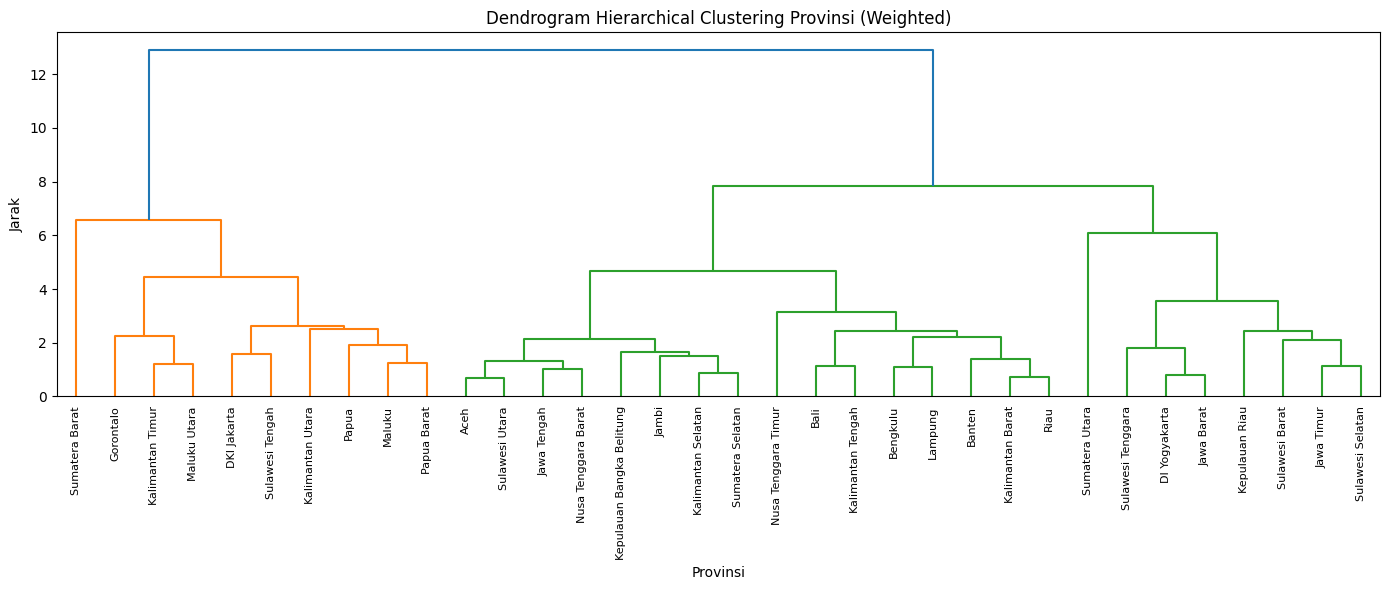

<Figure size 640x480 with 0 Axes>

In [16]:
# ======================================
# VISUALISASI DENDROGRAM
# ======================================
plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    labels=df_cluster.index,
    leaf_rotation=90
)
plt.title("Dendrogram Hierarchical Clustering Provinsi (Weighted)")
plt.xlabel("Provinsi")
plt.ylabel("Jarak")
plt.tight_layout()
plt.show()

# simpan gambar
plt.savefig(
    "dendrogram_hierarchical_provinsi.png",
    dpi=300,
    bbox_inches="tight"
)


In [17]:
# ================================
# MEMBENTUK CLUSTER FINAL
# ================================
n_cluster = 3

labels = fcluster(
    Z,
    t=n_cluster,
    criterion="maxclust"
)

df_hasil = df_cluster.copy()
df_hasil["cluster"] = labels


In [18]:
df_hasil_reset = df_hasil.reset_index()
df_review = df_hasil_reset.sort_values('cluster')[['Province','cluster']]
df_review

,Province,cluster
6,Gorontalo,1
5,DKI Jakarta,1
15,Kalimantan Utara,1
14,Kalimantan Timur,1
24,Papua Barat,1
23,Papua,1
20,Maluku Utara,1
19,Maluku,1
31,Sumatera Barat,1
28,Sulawesi Tengah,1


### Penjelasan
#### Provinsi telah di clustering berdasarkan harga komoditas di tiap provinsi + pembobotan yang telah diberikan untuk setiap komoditas. 

#### 1. Cluster 1 = Provinsi dengan harga Komoditas Tinggi berdasarkan keseluruhan provinsi
#### 2. Cluster 2 = Provinsi dengan harga Komoditas Sedang berdasarkan keseluruhan provinsi
#### 3. Cluster 3 = Provinsi dengan harga Komoditas Rendah berdasarkan keseluruhan provinsi

In [19]:
df_review.to_excel('/kaggle/working/df_review_province.xlsx', index=False)
